Dynamic One Day ahead forecast

[I 2025-02-07 13:08:25,165] A new study created in memory with name: no-name-86132e0c-1864-44a6-878c-c52e6917c41c


Data loaded. DataFrame shape: (4784, 14)


[I 2025-02-07 13:08:25,492] Trial 0 finished with value: 0.7931920767185916 and parameters: {'lags': 3, 'n_estimators': 162, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7931920767185916.
`start` time `2006-08-28 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2006-08-31 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
[I 2025-02-07 13:08:25,775] Trial 1 finished with value: 0.8584041962699028 and parameters: {'lags': 8, 'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7931920767185916.
[I 2025-02-07 13:08:26,231] Trial 2 finished with value: 0.6422163182320623 and parameters: {'lags': 5, 'n_estimators': 120, 'max_depth': 20, 'min_samples_split': 10, 'mi

Best hyperparameters: {'lags': 4, 'n_estimators': 299, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`start` position `0.0` corresponding to time `2022-12-23 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2023-01-02 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


historical forecasts:   0%|          | 0/514 [00:00<?, ?it/s]

Forecasting complete.
Test MAE: 0.2997582685099271
Test RMSE: 0.39621468457165454
Test R2: 0.9985713388911255


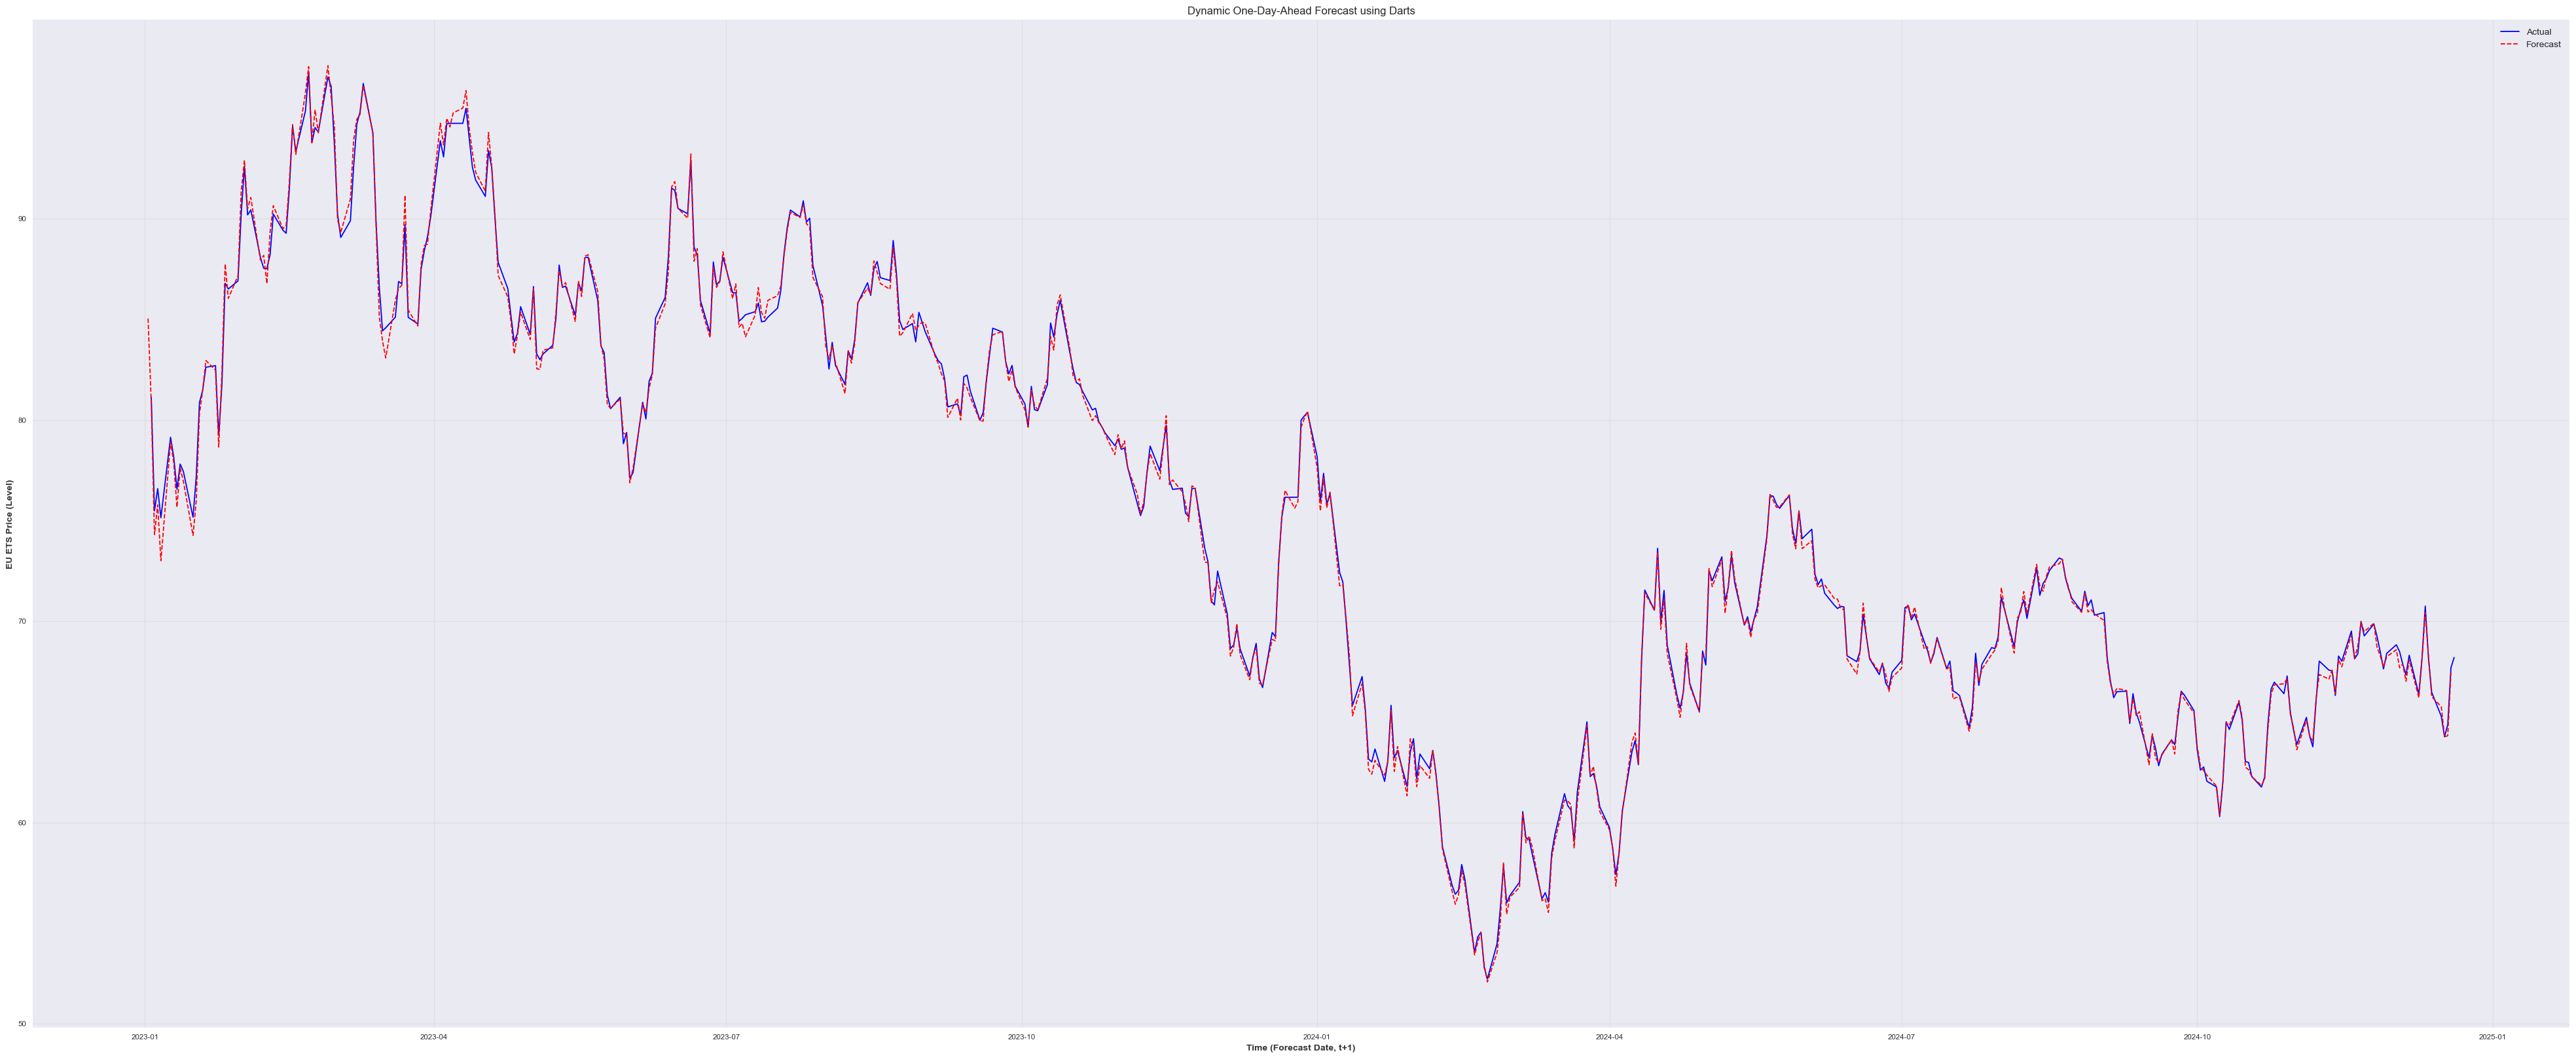

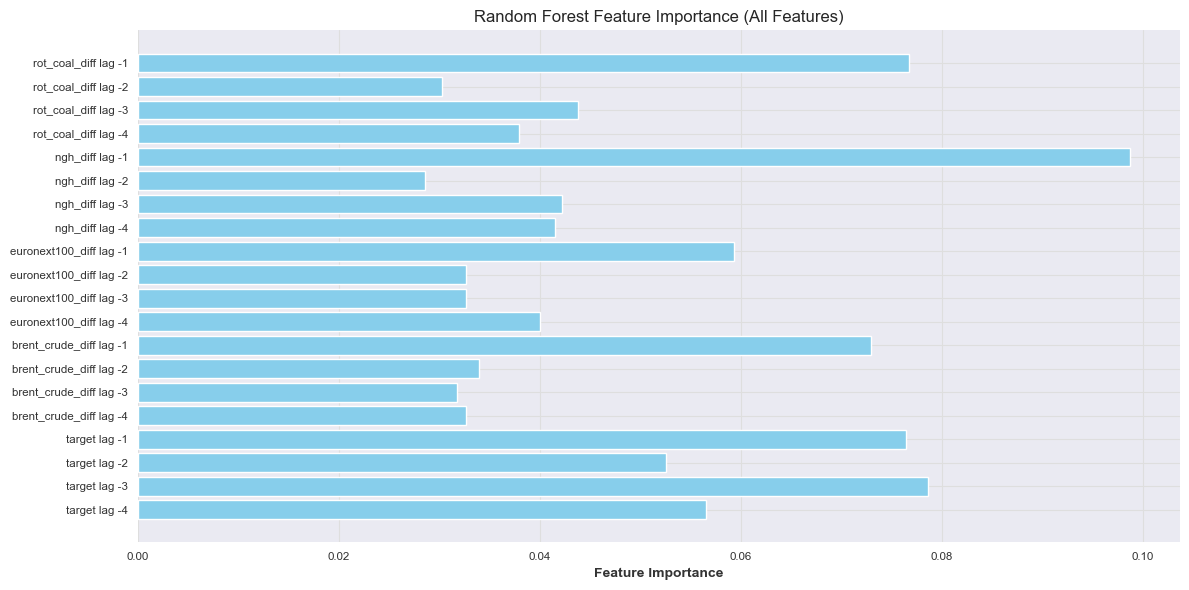

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import mae, rmse, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

# Load the CSV, parse dates (dayfirst=True), and sort.
file_path = "data/clean_euros_data_v4.csv"
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Reindex to business days.
df.set_index('date', inplace=True)
all_bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(all_bdays)

# Interpolate missing numeric values.
df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Save original eu_ets values.
df['eu_ets_level'] = df['eu_ets']

# One-day ahead forecast:
# forecast_date = date + 1 business day; actual_level = eu_ets_level shifted by -1.
df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(1)
df['actual_level'] = df['eu_ets_level'].shift(-1)
df['target'] = df['actual_level'] - df['eu_ets_level']

# Create differenced columns for any other numeric features.
keep_cols = ['date', 'eu_ets', 'eu_ets_level', 'forecast_date', 'actual_level', 'target']
cols_to_diff = [col for col in df.columns if col not in keep_cols]
for col in cols_to_diff:
    df[col + '_diff'] = df[col] - df[col].shift(1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Create Darts TimeSeries objects.
series_target = TimeSeries.from_dataframe(df, time_col='date', value_cols='target')
series_base   = TimeSeries.from_dataframe(df, time_col='date', value_cols='eu_ets_level')

# Create a covariate TimeSeries from all differenced columns (excluding 'target').
covariate_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
if covariate_cols:
    series_covariates = TimeSeries.from_dataframe(df, time_col='date', value_cols=covariate_cols)
else:
    series_covariates = None

print("Data loaded. DataFrame shape:", df.shape)
df.head()

def objective(trial):
    # Tune hyperparameters.
    n_lags = trial.suggest_int("lags", 1, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Darts expects negative lags.
    lags = list(range(-n_lags, 0))

    # Build a RegressionModel with output_chunk_length=1 for day-ahead forecasting.
    model = RegressionModel(
        lags=lags,
        lags_past_covariates=lags,
        model=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        output_chunk_length=1
    )

    forecast_horizon = 1  # Day-ahead forecast
    n_windows = 5
    if len(series_train) <= n_windows:
        return np.inf
    # Use the (n_windows+1)th time point as start.
    start_time = series_train.time_index[n_windows]

    # Fit the model once on the training data.
    model.fit(series_train, past_covariates=series_cov_train)

    try:
        # Fixed-window mode (no retraining for each forecast origin).
        pred = model.historical_forecasts(
            series_train,
            past_covariates=series_cov_train,
            forecast_horizon=forecast_horizon,
            start=start_time,
            stride=1,
            retrain=False,
            verbose=False
        )
    except Exception as e:
        print("Error in historical_forecasts:", e)
        return np.inf

    actual = series_train.slice_intersect(pred)
    error = rmse(actual, pred)
    return error

# Split the TimeSeries into training and test sets.
# Define the cutoff date
cutoff_date = pd.to_datetime('2022-12-23')

# Use the time_index property to get a pandas DatetimeIndex and then search for the cutoff
train_cutoff = series_target.time_index.searchsorted(cutoff_date)
series_train = series_target[:train_cutoff]
series_test  = series_target[train_cutoff:]
base_test    = series_base[train_cutoff:]
if series_covariates is not None:
    series_cov_train = series_covariates[:train_cutoff]
    series_cov_test  = series_covariates[train_cutoff:]
else:
    series_cov_train = None
    series_cov_test = None

# Run hyperparameter tuning.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Retrieve best hyperparameters.
n_lags = best_params["lags"]
lags = list(range(-n_lags, 0))

# Train the final model on the full training set.
final_model = RegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    model=RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    output_chunk_length=1
)
final_model.fit(series_train, past_covariates=series_cov_train)

# Forecast using an expanding-window mode (retrain=True).
forecast = final_model.historical_forecasts(
    series_test,
    past_covariates=series_cov_test,
    forecast_horizon=1,
    start=0.0,
    stride=1,
    retrain=True,
    verbose=True
)

# Reconstruct forecasted levels:
# Since target = actual_level - eu_ets_level, the forecasted level = base level + forecast.
# For day-ahead, shift the base series by 0 business day.
forecast_level = base_test.shift(0).slice_intersect(forecast) + forecast
actual_level = series_base.slice_intersect(forecast) + series_target.slice_intersect(forecast)
# For day-ahead, shifting actual_level by 1 ensures that its time index aligns with forecast_date.
actual_level = actual_level.shift(1)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

plt.figure(figsize=(50,20))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+1)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic One-Day-Ahead Forecast using Darts")
plt.legend()
plt.show()

# Build labels for target lags.
lags_for_plot = lags  # same as used in the model
target_feature_names = [f"target lag {lag}" for lag in lags_for_plot]
all_feature_names = target_feature_names.copy()

# If covariates exist, add labels for each covariate's lags.
if series_covariates is not None:
    covariate_cols = list(series_covariates.columns)
    for cov in covariate_cols:
        for lag in lags_for_plot:
            all_feature_names.append(f"{cov} lag {lag}")

# Get feature importances from the RandomForestRegressor.
importances = final_model.model.feature_importances_

if len(all_feature_names) != len(importances):
    print("Warning: Mismatch in feature names and importances.")
    print(f"Feature names: {len(all_feature_names)}, importances: {len(importances)}")

plt.figure(figsize=(12, 6))
plt.barh(all_feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (All Features)")
plt.tight_layout()
plt.show()


One-week ahead dynamic forecast


[I 2025-02-07 13:21:00,677] A new study created in memory with name: no-name-f1903493-c634-4fa3-a19b-2ed4c21fae5b


Data loaded. DataFrame shape: (4780, 14)


`start` time `2006-08-28 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2006-08-30 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
[I 2025-02-07 13:21:01,355] Trial 0 finished with value: 1.6993140306956385 and parameters: {'lags': 7, 'n_estimators': 206, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 1.6993140306956385.
`start` time `2006-08-28 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2006-09-04 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
[I 2025-02-07 13:21:02,017] Trial 1 finished with value: 1.3057208707591106 and parameters: {'lags': 10, 'n_estimators': 192

Best hyperparameters: {'lags': 1, 'n_estimators': 230, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`start` position `0.0` corresponding to time `2022-12-20 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2022-12-29 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


historical forecasts:   0%|          | 0/508 [00:00<?, ?it/s]

Forecasting complete.
Test MAE: 1.1399626782408885
Test RMSE: 1.4908205873231235
Test R2: 0.9800089769518643


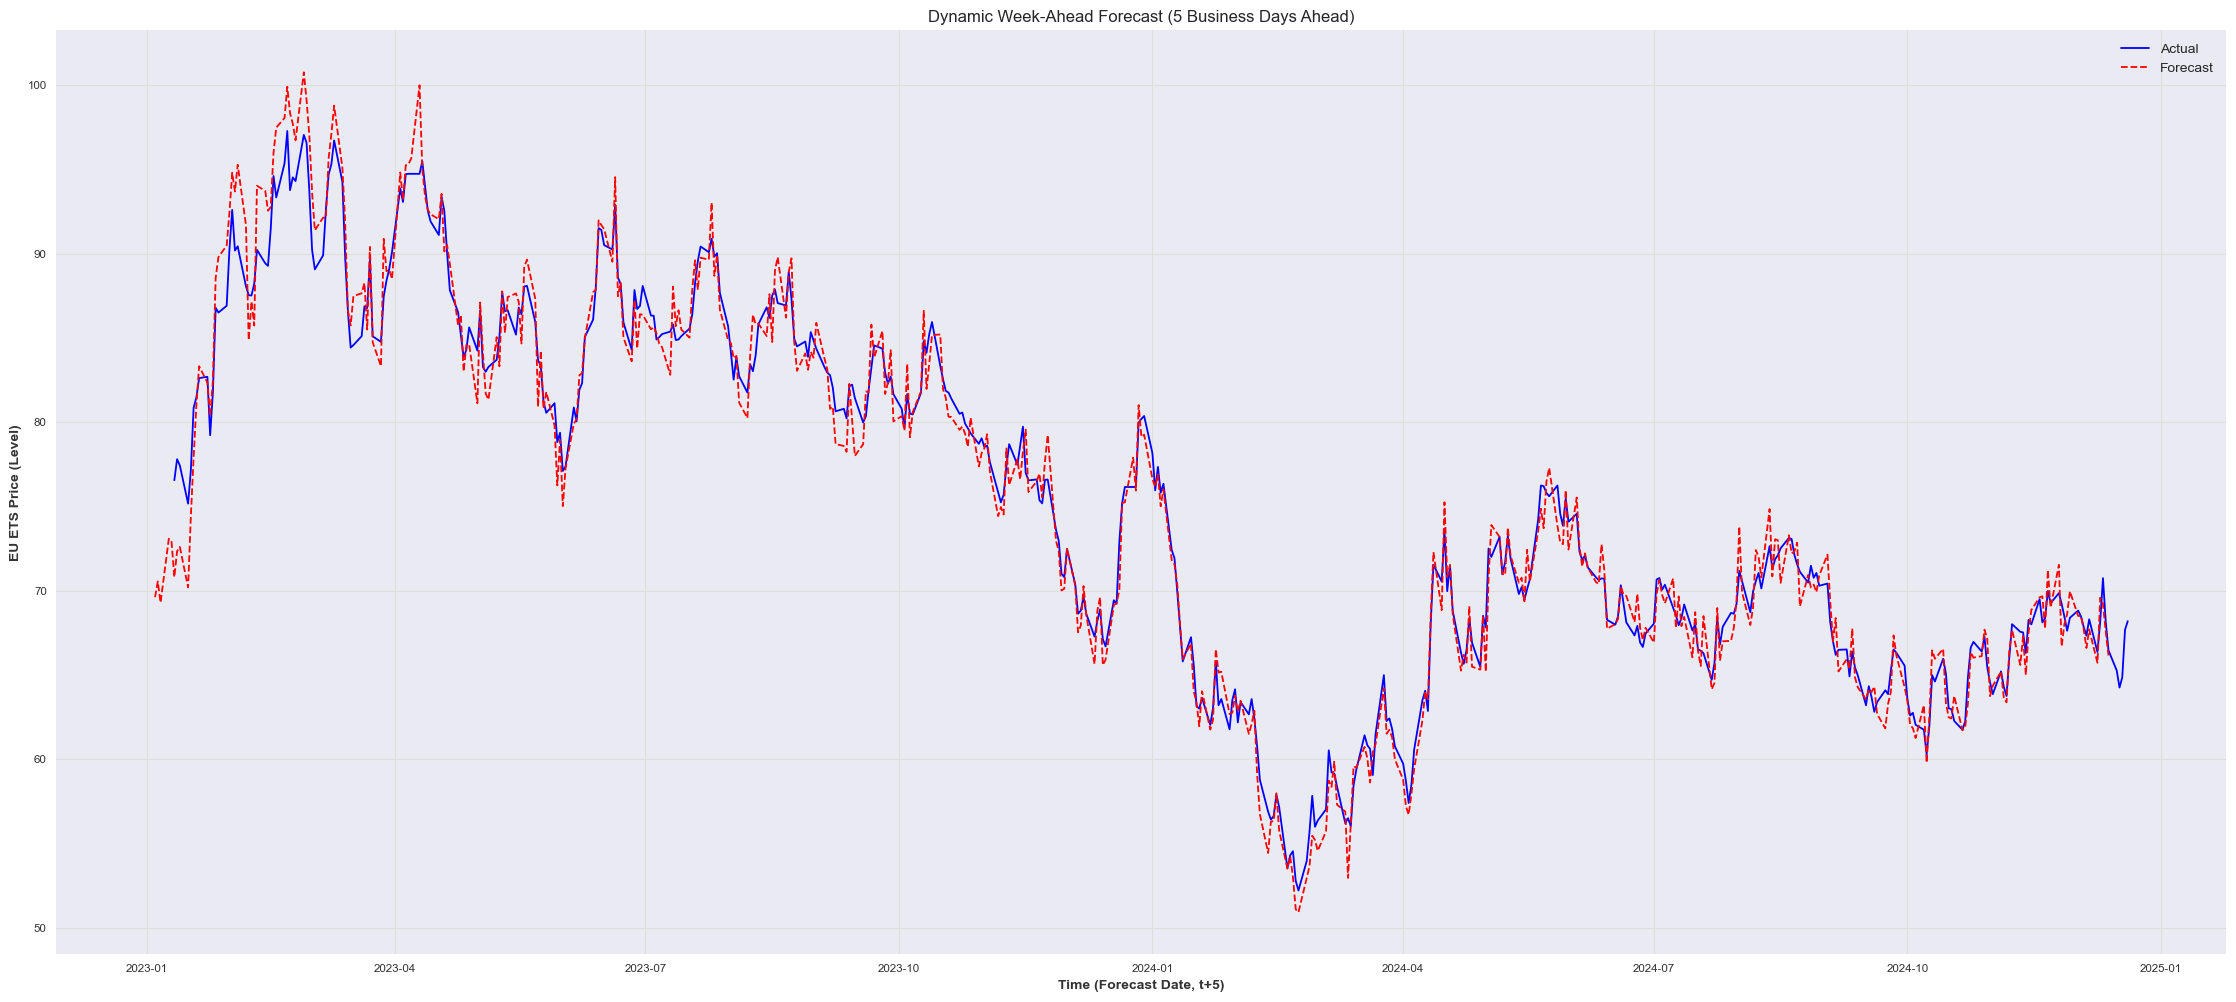

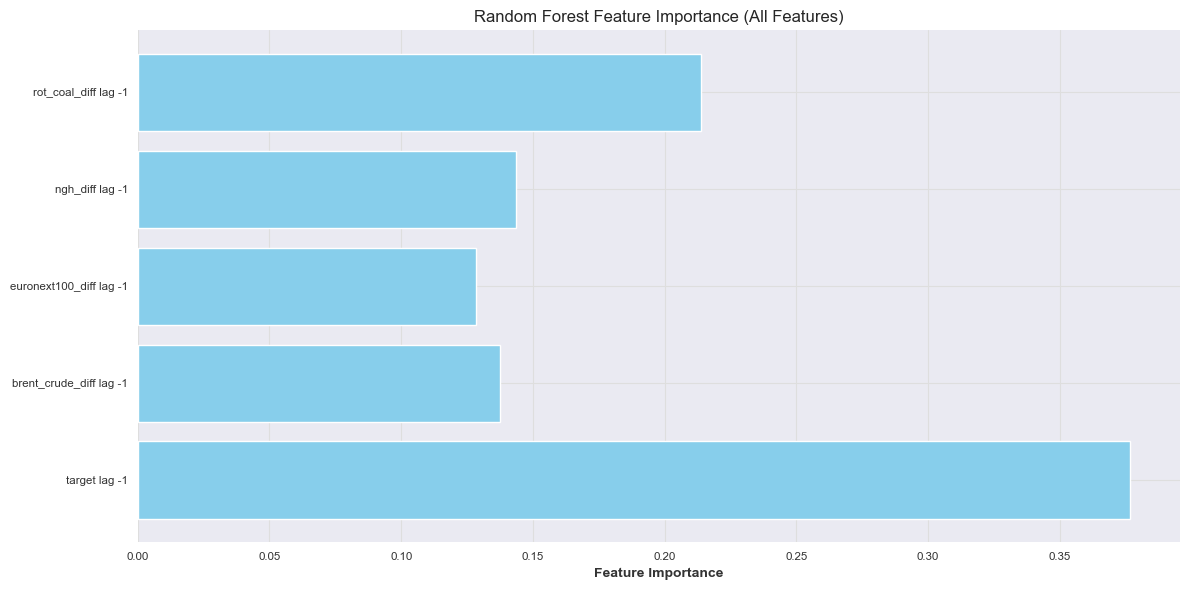

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import mae, rmse, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

# Load CSV data, parse dates (dayfirst=True), reindex to business days, and interpolate missing values.
# Then compute:
#   - eu_ets_level: copy of original 'eu_ets'
#   - forecast_date: date + 5 business days
#   - actual_level: eu_ets_level shifted by -5
#   - target: actual_level - eu_ets_level
# Also create differenced columns for other numeric features.

file_path = "data/clean_euros_data_v4.csv"

# Read and sort the data.
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Reindex to business days.
df.set_index('date', inplace=True)
all_bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(all_bdays)

# Interpolate missing numeric values.
df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Save original eu_ets values.
df['eu_ets_level'] = df['eu_ets']

# Compute week-ahead values:
df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(5)
df['actual_level'] = df['eu_ets_level'].shift(-5)
df['target'] = df['actual_level'] - df['eu_ets_level']

# Create differenced columns for any other numeric features.
keep_cols = ['date', 'eu_ets', 'eu_ets_level', 'forecast_date', 'actual_level', 'target']
cols_to_diff = [col for col in df.columns if col not in keep_cols]
for col in cols_to_diff:
    df[col + '_diff'] = df[col] - df[col].shift(1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Create Darts TimeSeries objects.
series_target = TimeSeries.from_dataframe(df, time_col='date', value_cols='target')
series_base   = TimeSeries.from_dataframe(df, time_col='date', value_cols='eu_ets_level')

# Create covariate TimeSeries from all differenced columns (excluding 'target').
covariate_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
if covariate_cols:
    series_covariates = TimeSeries.from_dataframe(df, time_col='date', value_cols=covariate_cols)
else:
    series_covariates = None

# Print some info.
print("Data loaded. DataFrame shape:", df.shape)
df.head()

def objective(trial):
    # Tune hyperparameters.
    n_lags = trial.suggest_int("lags", 1, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Darts requires negative lags.
    lags = list(range(-n_lags, 0))

    # Build model with output_chunk_length=5 for week-ahead forecasting.
    model = RegressionModel(
        lags=lags,
        lags_past_covariates=lags,
        model=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        output_chunk_length=5
    )

    forecast_horizon = 5
    n_windows = 5
    if len(series_train) <= n_windows:
        return np.inf
    # Use the (n_windows+1)th time point as start.
    start_time = series_train.time_index[n_windows]

    # Fit the model once on the training data.
    model.fit(series_train, past_covariates=series_cov_train)

    try:
        # Fixed-window mode: do not retrain for each forecast origin.
        pred = model.historical_forecasts(
            series_train,
            past_covariates=series_cov_train,
            forecast_horizon=forecast_horizon,
            start=start_time,
            stride=1,
            retrain=False,
            verbose=False
        )
    except Exception as e:
        print("Error in historical_forecasts:", e)
        return np.inf

    actual = series_train.slice_intersect(pred)
    error = rmse(actual, pred)
    return error

# Split the TimeSeries into training and test sets (80/20 split).
#train_cutoff = int(0.8 * len(series_target))

# Define the cutoff date
cutoff_date = pd.to_datetime('2022-12-20')

# Use the time_index property to get a pandas DatetimeIndex and then search for the cutoff
train_cutoff = series_target.time_index.searchsorted(cutoff_date)
series_train = series_target[:train_cutoff]
series_test  = series_target[train_cutoff:]
base_test    = series_base[train_cutoff:]
if series_covariates is not None:
    series_cov_train = series_covariates[:train_cutoff]
    series_cov_test  = series_covariates[train_cutoff:]
else:
    series_cov_train = None
    series_cov_test = None

# Run hyperparameter tuning.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Retrieve best hyperparameters.
n_lags = best_params["lags"]
lags = list(range(-n_lags, 0))

# Train the final model on the full training set.
final_model = RegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    model=RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    output_chunk_length=5
)
final_model.fit(series_train, past_covariates=series_cov_train)

# Perform final forecasting using an expanding window (retrain=True).
forecast = final_model.historical_forecasts(
    series_test,
    past_covariates=series_cov_test,
    forecast_horizon=5,
    start=0.0,
    stride=1,
    retrain=True,
    verbose=True
)

# Reconstruct forecasted levels.
# The target is the cumulative change over 5 business days.
forecast_level = base_test.shift(0).slice_intersect(forecast) + forecast
forecast_level = forecast_level.shift(0)

# Reconstruct actual levels: actual = base level + target.
actual_level = series_base.slice_intersect(forecast) + series_test.slice_intersect(forecast)
# Shift actual levels by 5 days for alignment with forecast_date.
actual_level = actual_level.shift(5)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

# Plot forecast versus actual.
plt.figure(figsize=(20, 20))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+5)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic Week-Ahead Forecast (5 Business Days Ahead)")
plt.legend()
plt.show()

# Build labels for target lags.
lags_for_plot = lags  # same as used in the model
target_feature_names = [f"target lag {lag}" for lag in lags_for_plot]
all_feature_names = target_feature_names.copy()

# If covariates exist, add labels for each covariate's lags.
if series_covariates is not None:
    covariate_cols = list(series_covariates.columns)
    for cov in covariate_cols:
        for lag in lags_for_plot:
            all_feature_names.append(f"{cov} lag {lag}")

# Get feature importances from the underlying RandomForestRegressor.
importances = final_model.model.feature_importances_

# Check for mismatches.
if len(all_feature_names) != len(importances):
    print("Warning: Mismatch in feature names and importances.")
    print(f"Feature names: {len(all_feature_names)}, importances: {len(importances)}")

plt.figure(figsize=(50, 20))
plt.barh(all_feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (All Features)")
plt.tight_layout()
plt.show()


Forecasting complete.
Test MAE: 1.1399626782408885
Test RMSE: 1.4908205873231235
Test R2: 0.9800089769518643


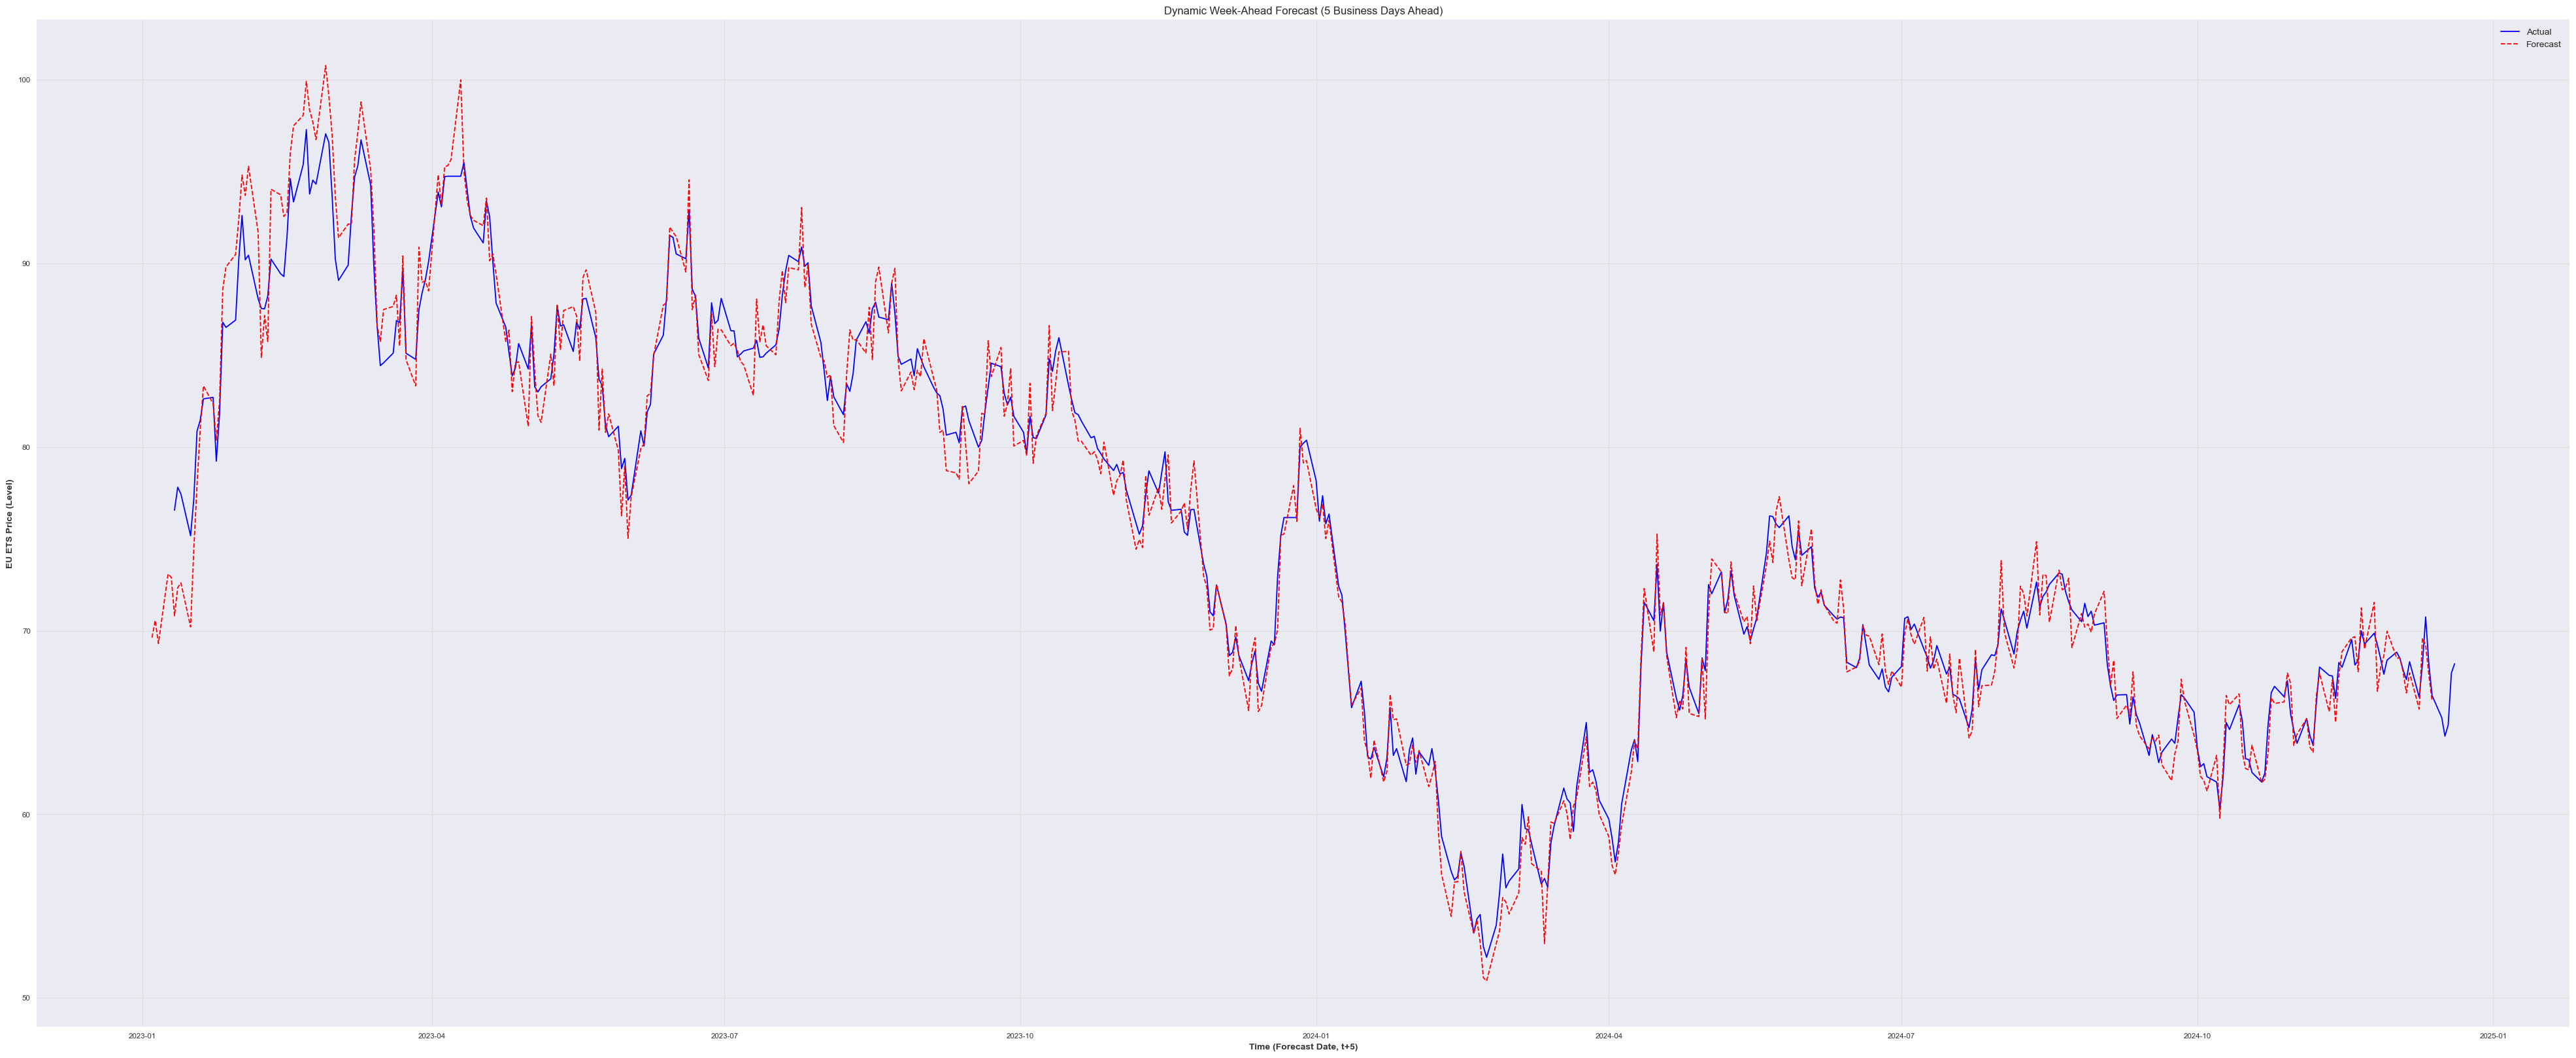

In [57]:
# The target is the cumulative change over 5 business days.
forecast_level = base_test.shift(0).slice_intersect(forecast) + forecast
forecast_level = forecast_level.shift(0)

# Reconstruct actual levels: actual = base level + target.
actual_level = series_base.slice_intersect(forecast) + series_test.slice_intersect(forecast)
# Shift actual levels by 5 days for alignment with forecast_date.
actual_level = actual_level.shift(5)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

# Plot forecast versus actual.
plt.figure(figsize=(50,20))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+5)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic Week-Ahead Forecast (5 Business Days Ahead)")
plt.legend()
plt.show()